In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

### Physical parameters

In [2]:
Γ = 0.0008613659531090722
θ = 1.53e-3
f = -0.53e-4

### Load dataset

In [3]:
data_dir = "../../MITgcm/experiments/rotated_BBTRE_rest/run/"
ds = open_mdsdataset(data_dir,iters=[3168000],ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag"], delta_t=60.)
ds_lev = open_mdsdataset(data_dir,iters=[3168000],ignore_unknown_vars=True,prefix=["levelDiag"], delta_t=60., levels=[50, 70, 90])

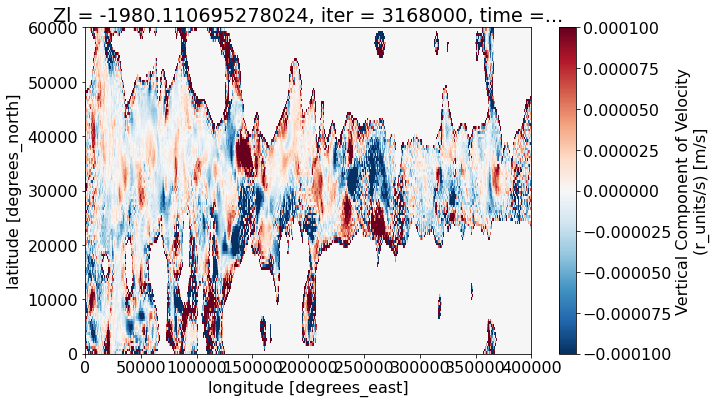

In [16]:
q = ds_lev.isel(Zl=0)['WVEL'].plot()
q.set_clim([-1.e-4,1.e-4])

### Pre-process dataset

In [4]:
ds, coords, grid = pre_process(ds)
ds, coords = add_cartesian_coordinates(ds, coords, θ)
ds = add_background_temp(ds, Γ)
ds = add_Nsq(ds, Γ)
ds, coords = add_hab_coordinates(ds, coords)

ds_lev, coords_lev, grid_lev = pre_process(ds_lev)
ds_lev, coords_lev = add_cartesian_coordinates(ds_lev, coords_lev, θ)
ds_lev = add_background_temp(ds_lev, Γ)
ds_lev, coords_lev = add_hab_coordinates(ds_lev, coords_lev)

### Interpolate to height-above-bottom coordinates

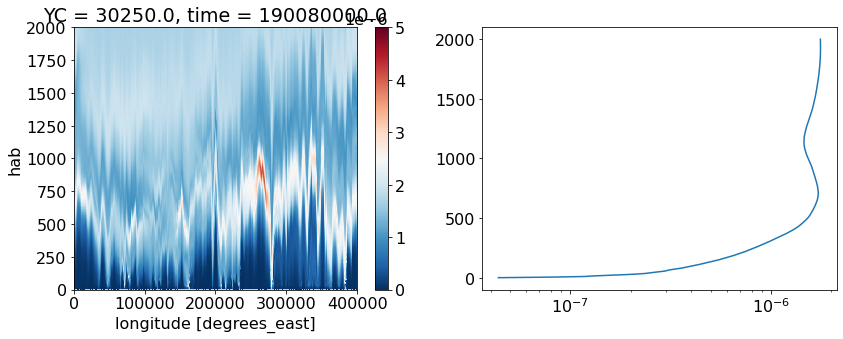

In [6]:
Nsq_hab = hab_interp(ds['Nsq'], vert_coord = 'Zl').compute()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
q = Nsq_hab.isel(YC=60, time=0).plot(y='hab')
q.set_clim([0., 5.e-6])

plt.subplot(1,2,2)
plt.semilogx(mean_profile(Nsq_hab.isel(YC=[60], time=0)), Nsq_hab['hab'])

plt.tight_layout()

### Calculate derived variables (ex: relative vorticity)

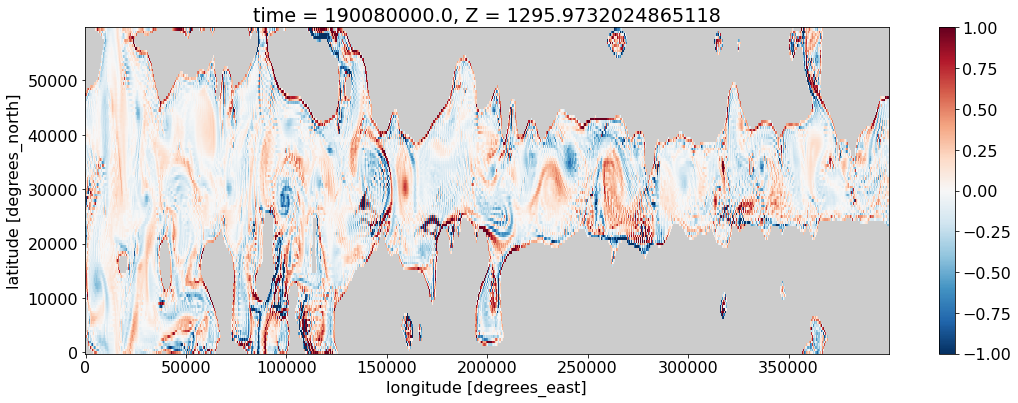

In [7]:
ζ_lev = (-grid_lev.diff(ds_lev.UVEL * coords_lev.dxC, 'Y', boundary='extend')
     +grid_lev.diff(ds_lev.VVEL * coords_lev.dyC, 'X', boundary='extend'))/coords_lev.rAz

plt.figure(figsize=(18,6))

ζ_lev = ζ_lev.where(ζ_lev != 0.)
q = (ζ_lev/f).isel(Z=0, time=-1).plot()
q.set_clim([-1,1])

plt.savefig("../../figures/BBTRE/vorticity_snapshot.png", dpi=150, bbox_inches='tight')

### Simulated hydrographic profiles

In [8]:
geo_XY = xr.open_dataset("../../MITgcm/experiments/rotated_BBTRE_rest/input/geocoords.nc").drop(["X", "Y"])

cdf = pd.read_csv("../../data/BBTRE_hydrography_z-binned.csv")
cdf = cdf[cdf['in canyon'] == True]

In [9]:
casts = cdf['cast number'].unique()

lons, lats = [], []
for cast in casts:
    lons.append(cdf[cdf['cast number']==cast]['longitude'].values[0])
    lats.append(cdf[cdf['cast number']==cast]['latitude'].values[0])

In [10]:
def global_argmin(da):
    xmin = da.min(dim=['Xr'])
    xargmin = da.argmin(dim='Xr').values
    yargmin = xmin.argmin(dim='Yr').values
    return [xargmin[yargmin], yargmin], xmin[yargmin].values

In [11]:
sample_locs = []
sample_casts = []
sample_coords = []
for c, cast in enumerate(casts):
    if np.isnan(lats[c]) | np.isnan(lons[c]): continue
    mindist = ((geo_XY['lat']-lats[c])**2 + (geo_XY['lon']-lons[c])**2)
    argmin, _ = global_argmin(mindist)
    if (
        (argmin[0] == 0) | (argmin[0] == geo_XY.dims['Xr']-1) |
        (argmin[1] == 0) | (argmin[1] == geo_XY.dims['Yr']-1)
    ):
        print(f"Cast {cast} is outside domain")
        continue
    sample_locs.append(argmin)
    sample_coords.append([lons[c], lats[c]])
    sample_casts.append(cast)

Cast 10 is outside domain
Cast 11 is outside domain
Cast 12 is outside domain
Cast 13 is outside domain
Cast 14 is outside domain
Cast 15 is outside domain
Cast 26 is outside domain
Cast 27 is outside domain


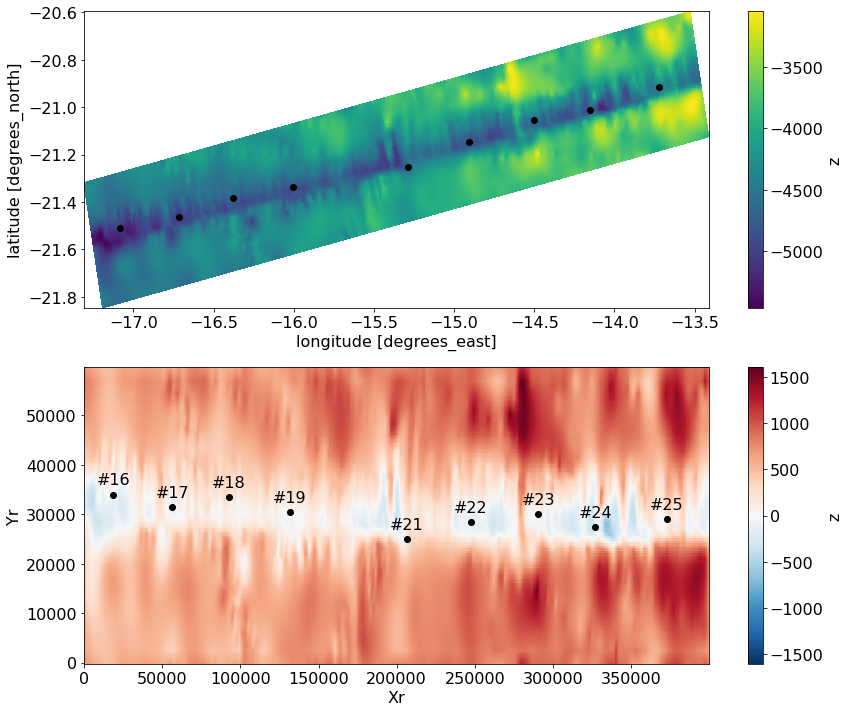

In [12]:
plt.figure(figsize=(14,12))

plt.subplot(2,1,1)
geo_XY['z_with_slope'].plot(x='lon', y='lat')
for loc in sample_locs:
    plt.plot(geo_XY['lon'].isel(Xr=loc[0], Yr=loc[1]).values, geo_XY['lat'].isel(Xr=loc[0], Yr=loc[1]).values, "ko")
    
plt.subplot(2,1,2)
geo_XY['z'].plot()
for c, loc in enumerate(sample_locs):
    x = geo_XY['Xr'].isel(Xr=loc[0]).values
    y = geo_XY['Yr'].isel(Yr=loc[1]).values
    plt.plot(x, y, "ko")
    label = f"#{sample_casts[c]}"
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    
plt.savefig("../../figures/BBTRE/canyon_casts_map.png", dpi=150, bbox_inches="tight")

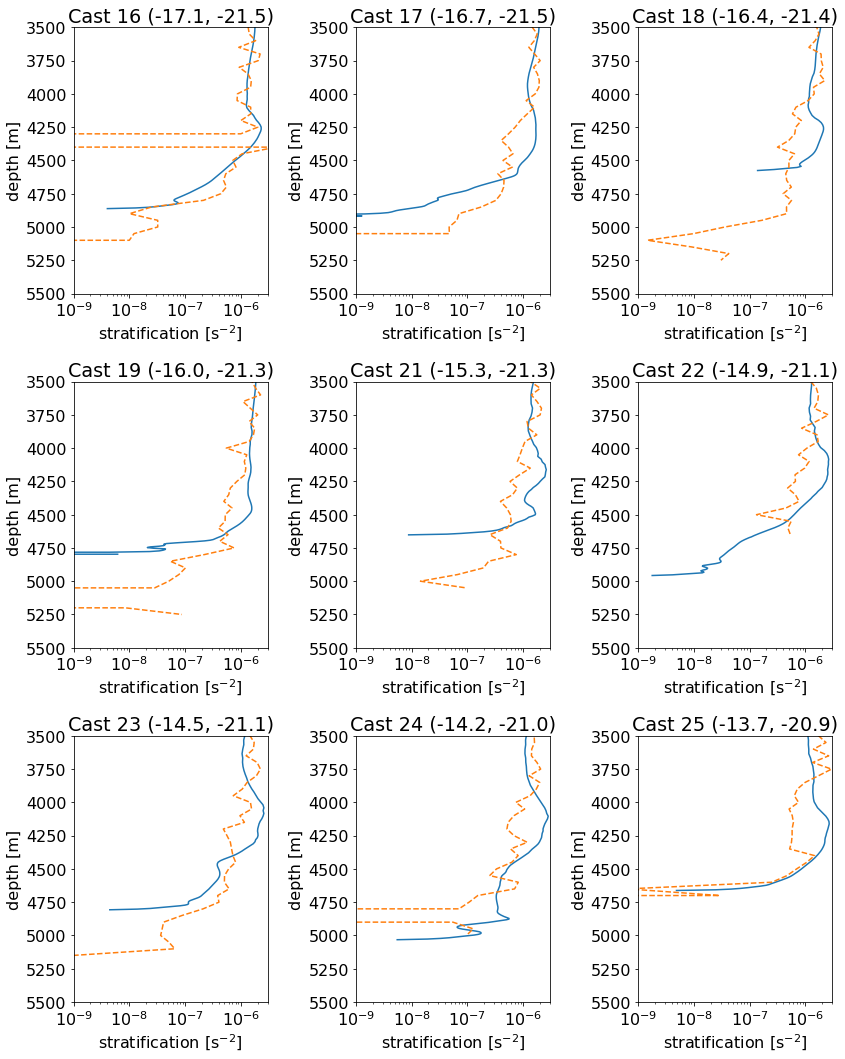

In [13]:
plt.figure(figsize=(12, 15))

for c, loc in enumerate(sample_locs):
    plt.subplot(3,3,c+1)
    tmp = ds['Nsq'].isel(XC=loc[0], YC=loc[1], time=-1)
    plt.semilogx(tmp, -(ds['Zl']+geo_XY['z_with_slope'].min().values.copy().astype('>f8')))
    
    tmp_df = cdf[cdf['cast number']==casts[c]]
    plt.semilogx(tmp_df['Nsq'], tmp_df['pressure'], '--')
    plt.ylim([5500, 3500])
    plt.title(f"Cast {sample_casts[c]} ({round(sample_coords[c][0],1)}, {round(sample_coords[c][1],1)})")
    plt.xlim([1.e-9,3.e-6])
    plt.xlabel(r"stratification [s$^{-2}$]")
    plt.ylabel("depth [m]")
    
plt.tight_layout()
plt.savefig("../../figures/BBTRE/canyon_casts_comparison.png", dpi=150, bbox_inches="tight")

In [14]:
ds['ϵ'] = ds['KVDIFF']*ds['Nsq']/0.2

(300.0, 2000.0)

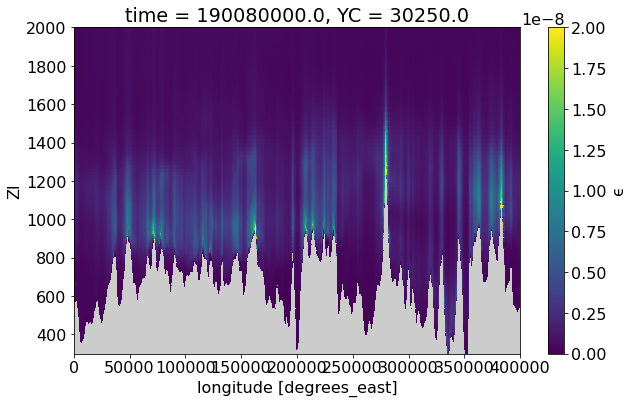

In [28]:
q = ds['ϵ'].isel(time=-1, YC=60).plot(cmap='viridis')
q.set_clim([0, 2.e-8])
plt.ylim([300,2000])

In [ ]:
ϵ_hab = hab_interp(ds['ϵ'], vert_coord = 'Zl').compute()

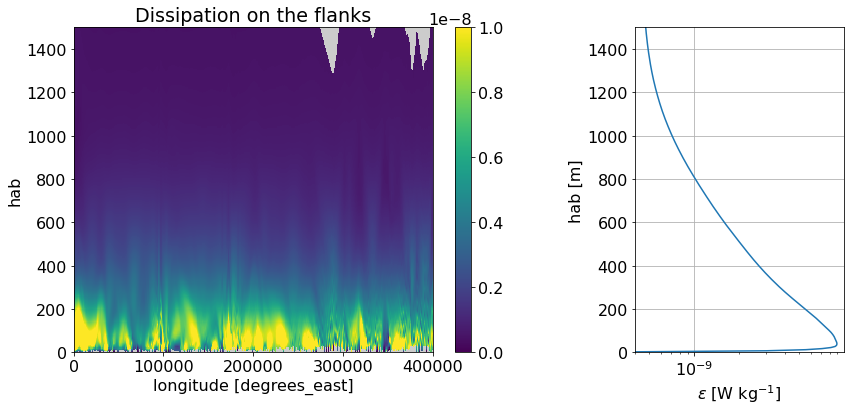

In [54]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
q = ϵ_hab.isel(YC=20, time=0).plot(y='hab', cmap='viridis')
q.set_clim([0., 1.e-8])
plt.title("Dissipation on the flanks")
plt.ylim([0,1500])

plt.subplot(1,4,3)
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[20], time=0)), ϵ_hab['hab'])
plt.xlim([4.e-10, 1.e-8])
plt.xticks([1.e-9])
plt.grid(True)
plt.ylabel("hab [m]")
plt.xlabel("$\epsilon$ [W kg$^{-1}$]")
plt.ylim([0,1500])

plt.tight_layout()

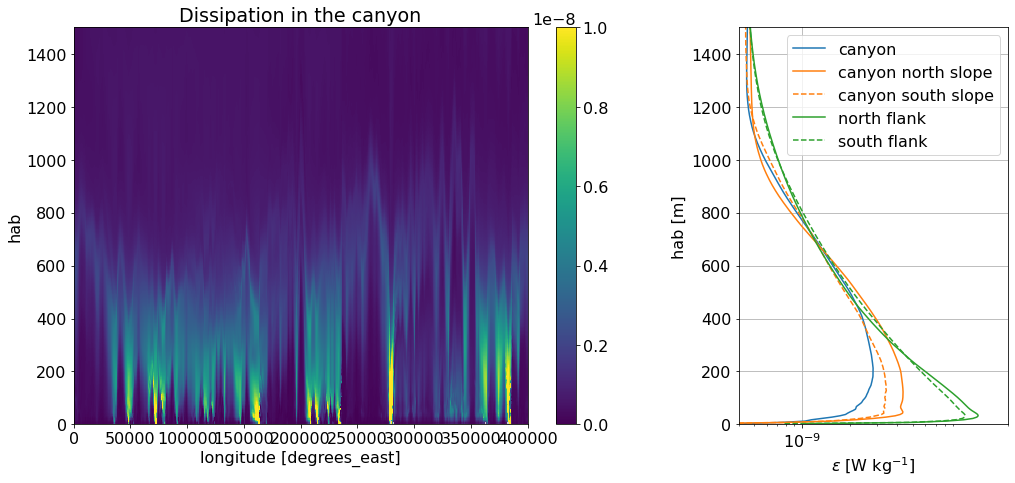

In [64]:
plt.figure(figsize=(19,7))

plt.subplot(1,2,1)
q = ϵ_hab.isel(YC=60, time=0).plot(y='hab', cmap='viridis')
q.set_clim([0., 1.e-8])
plt.title("Dissipation in the canyon")
plt.ylim([0,1500])

plt.subplot(1,4,3)
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[60], time=0)), ϵ_hab['hab'], label = "canyon")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[65], time=0)), ϵ_hab['hab'], "C1-", label = "canyon north slope")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[55], time=0)), ϵ_hab['hab'], "C1--", label = "canyon south slope")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[90], time=0)), ϵ_hab['hab'], "C2-", label = "north flank")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[30], time=0)), ϵ_hab['hab'], "C2--", label = "south flank")
plt.xlim([4.e-10, 2.e-8])
plt.xticks([1.e-9])
plt.grid(True)
plt.ylabel("hab [m]")
plt.xlabel("$\epsilon$ [W kg$^{-1}$]")
plt.ylim([0,1500])
plt.legend(loc='upper right')

plt.tight_layout()

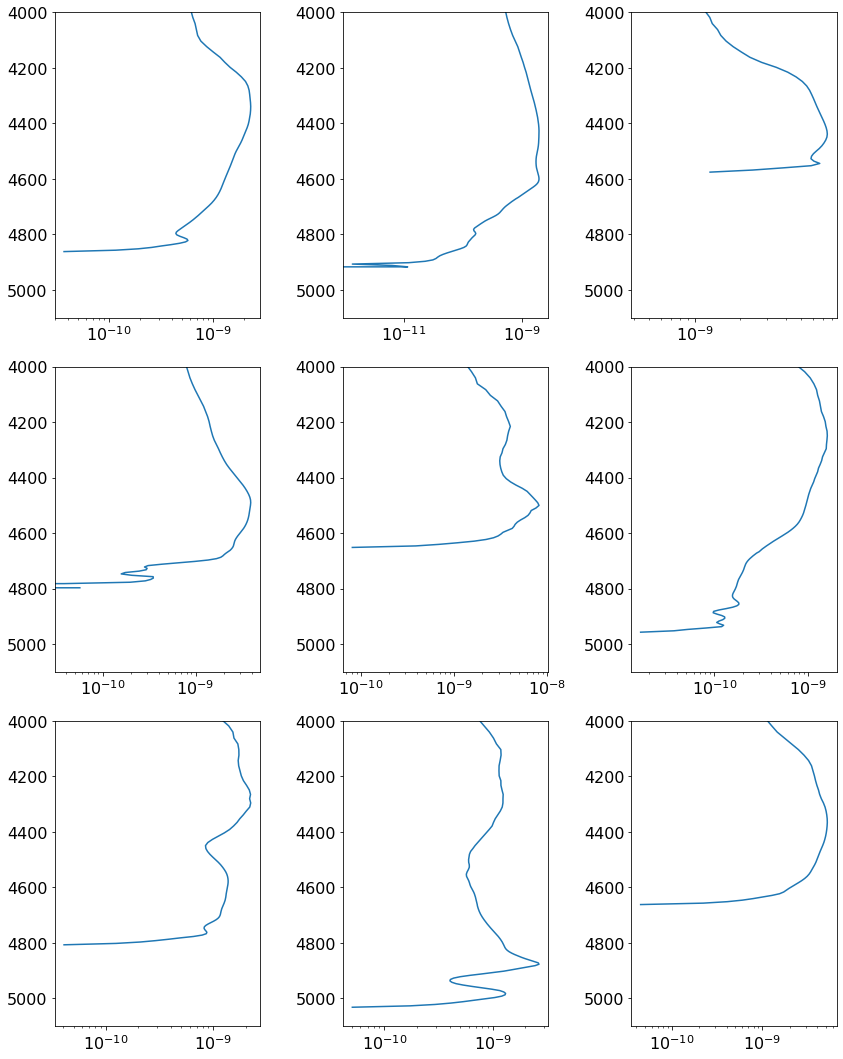

In [17]:
plt.figure(figsize=(12, 15))

for c, loc in enumerate(sample_locs):
    plt.subplot(3,3,c+1)
    tmp = ds['ϵ'].isel(XC=loc[0], YC=loc[1], time=-1)
    plt.semilogx(tmp, -(ds['Zl']+geo_XY['z_with_slope'].min().values.copy().astype('>f8')))
    plt.ylim([5100, 4000])
    
plt.tight_layout()
plt.savefig("../../figures/BBTRE/canyon_casts_comparison_epsilon.png", dpi=150, bbox_inches="tight")

### Plotting

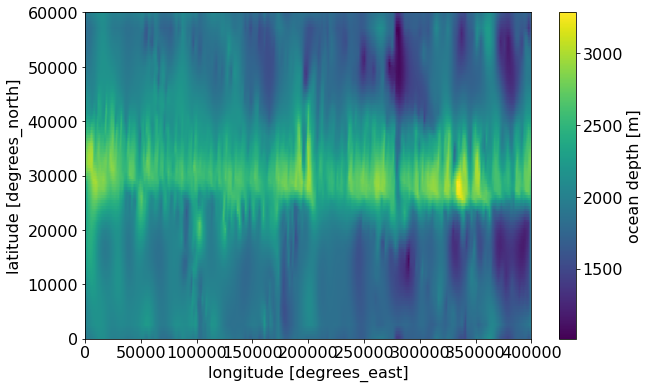

In [382]:
coords['Depth'].plot()

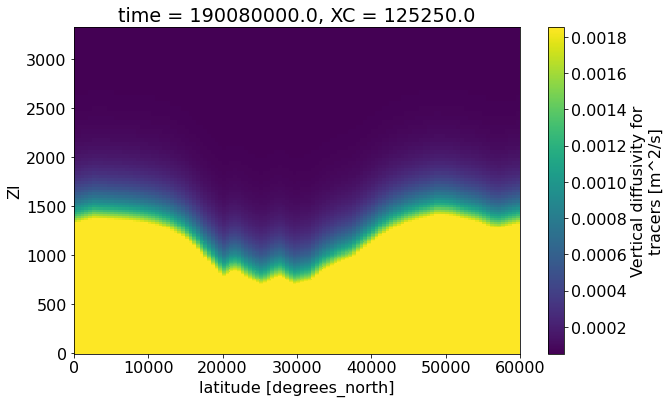

In [383]:
ds['KVDIFF'].isel(XC=250, time=0).plot()

In [ ]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1, facecolor=(.8, .8, .8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
ds['UVEL'].isel(time=-1).sel(Z=900, method='nearest').plot(cmap=div_cmap)

plt.subplot(3,1,2, facecolor=(.8, .8, .8))
q = ds['UVEL'].isel(time=-1).sel(YC=3e4, method='nearest').plot(x='Xr_U', y='Zr_U')
q.set_clim([-2e-2, 2e-2])
ds['THETA_BG'].isel(time=-1).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
plt.ylim([200,2500])

plt.subplot(3,1,3, facecolor=(.8, .8, .8))
q = ds['UVEL'].isel(time=-1).sel(XG=1.5e5, method='nearest').plot(x='YC', y='Zr_U')
q.set_clim([-2e-2, 2e-2])
ds['THETA_BG'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot.contour(x='YC', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
plt.ylim([200,2500])
plt.xlim([6.e4, 0.])

plt.tight_layout()
plt.savefig("../../figures/BBTRE_u.png", bbox_inches='tight', dpi=100.)

In [ ]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1, facecolor=(.8, .8, .8))
ds['WVEL'] = ds['WVEL'].where(ds['WVEL'] != 0.)
ds['WVEL'].isel(time=-1).sel(Zl=900, method='nearest').plot(cmap=div_cmap)

plt.subplot(3,1,2, facecolor=(.8, .8, .8))
q = ds['WVEL'].isel(time=-1).sel(YC=3e4, method='nearest').plot(x='Xr_W', y='Zr_W')
ds['THETA_BG'].isel(time=-1).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.05))
plt.ylim([200,2500])

plt.subplot(3,1,3, facecolor=(.8, .8, .8))
q = ds['WVEL'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot(x='YC', y='Zr_W')
ds['THETA_BG'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot.contour(x='YC', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.05))
plt.ylim([200,2500])
plt.xlim([6.e4, 0.])

plt.tight_layout()
plt.savefig("../../figures/BBTRE_w.png", bbox_inches='tight', dpi=100.)

In [ ]:
plt.figure(figsize=(14,8))

ζ = ζ.where(ζ != 0.)
p = (ζ/f).isel(time=-1).sel(Z=1200, method='nearest').plot(cmap=div_cmap)
p.set_clim([-1.,1.])

In [ ]:
plt.figure(figsize=(14,8))

ζ = ζ.where(ζ != 0.)
p = (ζ/f).isel(time=-1).sel(Z=2500, method='nearest').plot(cmap=div_cmap)
p.set_clim([-0.1,0.1])

